# Tutorial for Introduction to ML Lecture

version 0.1, September 2023

Bryan Scott, CIERA/Northwestern

## Problem 1: Bayes Classifiers

A good starting point for Machine Learning is the Bayes classifier. The basic idea is to assign the most probable label to each data point using Bayes theorem, we take:

$$
p(y | x_n) \propto p(y)p(x_i, ..., x_n | y)
$$

where y is a label for a data point and the $x_n$ are the features of the data that we want to use to classify each data point. A $\textit{Naive} Bayes$ classifier makes an important simplifying assumptions that gives it the name - it assumes that the conditional probabilities are independent, $p(x_i, ..., x_n | y) = p(x_i|y)... p(x_n | y)$. That is, the probability of observing any individual feature doesn't depend on any of the other features. Our task is to construct this classifier from a set of examples we've observed previously and compare it to new data. 

### Part 0: Load and split the data

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [28]:
# lsst_data[0:1000].to_csv('session_19_DC2_subset.csv')

### Loading and splitting the data. 

Read in the data, then start by selecting the id, fluxes, and object truth type in the lsst data file you've been provided. 

Once you have selected those, randomly split the data into two arrays, one containing 80% of the data, and a second array containing 20% of the data. 

In [14]:
lsst_data = pd.read_csv('data/table_data.lsst.cloudapi.csv')

# solved 

lsst_data_to_classify = lsst_data[['id', 'flux_g', 'flux_i', 'flux_r', 'flux_u', 'flux_y', 'flux_z', 'truth_type']]
random_data = lsst_data_to_classify.sample(n=1000)

random_data.to_csv('simulated_extragalactic_data.csv')

train_data = random_data.iloc[0:800]
test_data = random_data.iloc[800:1000]

# unsolved 

# lsst_data_to_classify = 
# random_data = 

# train_data = 
# test_data = 

In [12]:
random_data[random_data['truth_type'] == 1]

,id,flux_g,flux_i,flux_r,flux_u,flux_y,flux_z,truth_type
48344,11568460784,10.56370,29.4790,16.4745,3.79227,76.0767,45.1033,1
17666,11626701310,151.17900,267.0960,157.2470,159.34900,287.3300,292.1570,1
47807,11566532886,19.39760,30.3091,24.4655,19.74380,72.5930,47.4641,1
8352,11564209917,279.80400,1925.0200,754.7330,185.44200,3909.2000,3307.4300,1
37532,11688356116,5.14646,18.9025,11.6335,3.25081,21.5846,20.3508,1
...,...,...,...,...,...,...,...,...
49702,11569887601,11.08150,30.9775,18.1020,2.29094,72.4049,52.0237,1
14466,11562553858,70.30830,304.1930,200.4590,16.73550,454.9000,385.6030,1
23077,11638125364,86.73320,77.4096,83.8354,69.89100,77.4372,77.5890,1
42190,11691538627,5.42994,24.6955,11.7521,2.15128,87.6585,49.3406,1


### Part 1: Estimate Class Frequency in the training set

One of the ingredients in our classifier is p(y), the unconditional class probabilities. 

We can get this by counting the number of rows belonging to each class in train_data and dividing by the length of the training data set. 

In [30]:
# solved

def estimate_class_probabilities(x_train): 
    """
    Computes unconditional class probabilities. 
     
    Args:
        x_train (array): training data for the classifier
 
    Returns:
        ints p1, p2: unconditional probability of an element of the training set belonging to class 1
    """
    
    p1 = len(x_train.loc[x_train['truth_type'] == 1])/800
    p2 = len(x_train.loc[x_train['truth_type'] == 2])/800
    
    return p1, p2

p1, p2 = estimate_class_probabilities(test_data)


### Part 2:  Feature Likelihoods

We are assuming that the relationship between the classes and feature probabilities are related via:

$p(x_i, ..., x_n | y) =  p(x_i|y)... p(x_n | y)$

however, we still need to make an assumption about the functional form of the $p(x_n | y)$. As a simple case, we will assume p(x_n | y) follows a Gaussian distribution given by:

$$
p(x_i | y) = \frac{1}{\sqrt{2 \pi \sigma_y}} \exp{\left(-\frac{(x_i - \mu)^2}{\sigma_y^2}\right)}
$$

and we will make a maximum likelihood estimate of $\mu$ and $\sigma_y$ from the data. This means using empirical estimates $\bar{x}$ and $\hat{\sigma}$ as estimators of the true parameters $\mu$ and $\sigma_y$. 

Write a fitting function that takes the log of the fluxes and returns an estimate of the parameters of the per-feature likelihoods for each class.

In [31]:
# solved

def per_feature_likelihood_parameters(x_train, label):
    """
    Computes MAP estimates for the class conditional likelihood. 
     
    Args:
        x_train (array or pd series): training data for the classifier
        label (int): training labels for the classifier 
 
    Returns:
        means, stdevs (array): MAP estimates of the Gaussian conditional probability distributions for a specific class
    """
    
    means = np.log(x_train.loc[x_train['truth_type'] == label][['flux_g', 'flux_r', 'flux_i', 'flux_u', 'flux_y']]).mean()
    stdevs = np.log(x_train.loc[x_train['truth_type'] == label][['flux_g', 'flux_r', 'flux_i', 'flux_u', 'flux_y']]).std()
    
    return means, stdevs



### Part 3: MAP Estimates of the Class Probabilities

Now that we have the unconditional class probabilities and the parameters of the per feature likelihoods in hand, we can put this all together to build the classifier. Use the methods you have already written to write a function that takes in the training data and returns fit parameters. Once you have done that, write a method that takes the fit parameters as an argument and predicts the class of new (and unseen) data. 

In [32]:
# build the classifier

# solved 

def fit(x_train):
    """
    Convenience function to perform fitting on the training data
     
    Args:
        x_train (array or pd series): training data for the classifier
 
    Returns:
        p1, p2, class_1_mean, class_2_mean, class_1_std, class_2_std: see documentation for per_feature_likelihood_parameters
    """
    
    p1, p2 = estimate_class_probabilities(x_train)
    
    class_1_mean, class_1_std = per_feature_likelihood_parameters(x_train, 1)
    class_2_mean, class_2_std = per_feature_likelihood_parameters(x_train, 2)
    
    return p1, p2, class_1_mean, class_2_mean, class_1_std, class_2_std

In [33]:
class_probability, class_means, class_dev = fit(train_data)

In [34]:
# solved 

def predict(x_test, class_probability, class_means, class_dev):
    """
    Predict method
     
    Args:
        x_test (array): data to perform classification on
        class_probability (array): unconditional class probabilities
        class_means, class_dev (array): MAP estimates produced by the fit method
 
    Returns:
        predict_List (list): class membership predictions
    """
    
    
    flux_g, flux_r, flux_i, flux_u, flux_y = np.log(np.array(x_test[['flux_g', 'flux_r', 'flux_i', 'flux_u', 'flux_y']])).T

    prob_1 = class_probability[0] * norm.pdf(flux_i, class_means[0]['flux_i'],class_dev[0]['flux_i']) * norm.pdf(flux_r, class_means[0]['flux_r'],class_dev[0]['flux_r'])* norm.pdf(flux_g, class_means[0]['flux_g'],class_dev[0]['flux_g'])* norm.pdf(flux_u, class_means[0]['flux_u'],class_dev[0]['flux_u'])* norm.pdf(flux_y, class_means[0]['flux_y'],class_dev[0]['flux_y'])
    prob_2 = class_probability[1] * norm.pdf(flux_i, class_means[1]['flux_i'],class_dev[1]['flux_i'])* norm.pdf(flux_r, class_means[1]['flux_r'],class_dev[1]['flux_r']) * norm.pdf(flux_g, class_means[1]['flux_g'],class_dev[1]['flux_g']) * norm.pdf(flux_u, class_means[1]['flux_u'],class_dev[0]['flux_u'])* norm.pdf(flux_y, class_means[1]['flux_y'],class_dev[1]['flux_y'])
    
    predict_list = np.zeros(len(prob_1))
        
    for i in range(0, len(prob_1)):
        if prob_1[i] >= prob_2[i]:
            predict_list[i] = int(1)
            
        if prob_1[i] < prob_2[i]:
            predict_list[i] = int(2)
    
    return predict_list

In [35]:
test_data = test_data[~(test_data == 0).any(axis = 1)]

In [36]:
predict(test_data, class_probability, class_means, class_dev)

array([1., 1., 2., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2.,
       1., 1., 2., 1., 1., 1., 1., 1., 2., 1., 2., 1., 1., 2., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1.,
       1., 2., 1., 1., 1., 1., 2., 1., 2., 1., 1., 2., 2., 1., 1., 2., 2.,
       2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1.,
       1., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1.,
       1., 1., 2., 2., 1., 1., 1., 2., 2., 1., 1., 1., 1., 1., 2., 2., 2.,
       1., 1., 2., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 2.,
       2., 2., 1., 1., 1., 1., 1., 2., 1., 1., 1., 2., 2., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 2., 1., 2., 1., 1., 1.])

### Part 4: Metrics

After creating a classifier, you now want to evaluate it in terms of how often it correctly and incorrectly classifies the objects in your training set. To do this, we'll design a confusion matrix. A confusion matrix is a matrix whose entries are the counts of the predicted vs actual class. For example, the first entry is the count of objects that are predicted to be of class 1 and actually are of class 1 and so on, while the off-diagonal elements would be instances of class 1 that are predicted to be of class 2, and instances of class 2 that are predicted to be of class 1. 

In [37]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)


In [38]:
df_confusion = pd.crosstab(test_data['truth_type'] ,predict(test_data, class_probability, class_means, class_dev))

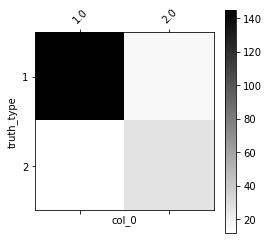

In [39]:
plot_confusion_matrix(df_confusion)

## Problem 2: The Cramer-Rao bound (pen & paper, challenging)

As we saw in the lecture, the Cramer-Rao bound is an important result in statistics that has intuitive consequences for many applied problems in ML. The proof of the Cramer-Rao bound can be insightful to work through. 

The starting point for the proof of the bound is the Cauchy-Schwarz inequality, which can be used to show that:

$$
[Cov(U, V)]^2 \le Var(U)Var(V)
$$

Starting from the definitions that U = T(X), where T(X) is an estimator of some parameter $\theta$ of the distribution $f(X|\theta)$ from which the data is sampled, and V = $\frac{\partial}{\partial \theta} log f(X |\theta)$. Use the Cauchy-Schwarz inequality to show the Cramer-Rao bound for these choices of U and V. 

$\textit{Hint:}$ you will need the fact that the $\mathbb{E}(V) = 0$, where $\mathbb{E}$ is the expectation of a random variable.